# CMSE 890 Project

### Autor: Fatemeh Fathi Niazi

___
## Preparing the libraries and directories.

In [2]:
# Import libraries
import os
import pickle
import numpy as np 
import pandas as pd 
import random
from time import perf_counter

from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.preprocessing import  StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.regularizers import l2

# import libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns

PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)


def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

2023-04-28 17:39:29.619095: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


___
## Loading the dataset

Text(0.5, 0.98, 'Different Channels of Image')

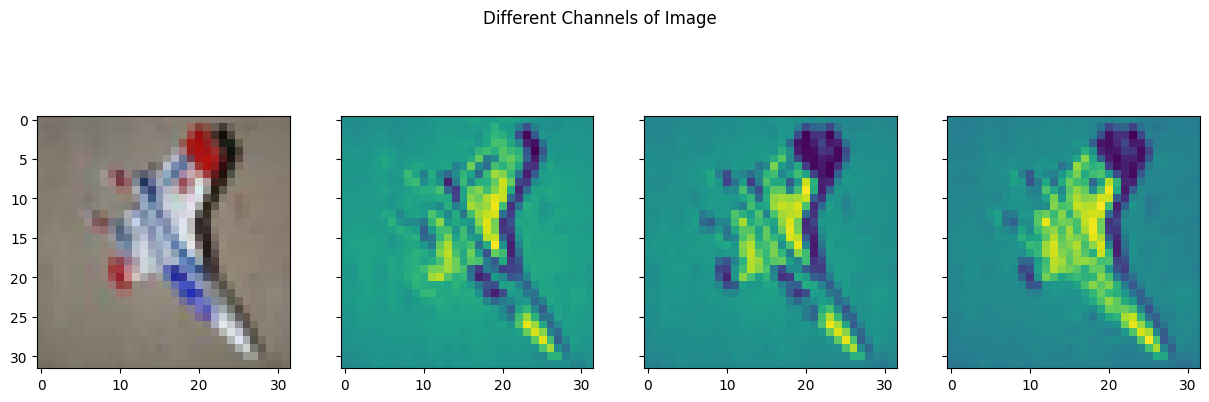

In [3]:
#  Loading the training dataset.
file_names = [f'data_batch_{i}' for i in range(1,6)]
X, Y = [], []
for i,file_name in enumerate(file_names):

    with open(os.path.join('cifar-10-batches-py' , file_name ), 'rb') as fo:
        dic = pickle.load(fo, encoding='bytes')
        

    X.append(dic[b'data'])
    Y.append(np.array(dic[b'labels']).reshape(-1, 1))
X_train_raw = np.row_stack(X)
y_train = np.row_stack(Y)

# Load the testing dataset. 
with open(os.path.join('cifar-10-batches-py', 'test_batch'), 'rb') as fo:
    dic = pickle.load(fo, encoding='bytes')
X_test_raw = dic[b'data']
y_test = np.array(dic[b'labels']).reshape(-1, 1)

# Reshape the data.
X_train_raw = X_train_raw.reshape(50000,32,32,3 , order = 'F')
X_test_raw  = X_test_raw.reshape(-1, 32, 32, 3, order='F')
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship',' truck']

# plotting the original image and the RGB channels
image = X_train_raw[30,:,:,:]
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True)
f.set_figwidth(15)
ax1.imshow(image)

# RGB channels
# CHANNELID : 0 for Red, 1 for Green, 2 for Blue. 
ax2.imshow(image[:, : , 0]) #Red
ax3.imshow(image[:, : , 1]) #Green
ax4.imshow(image[:, : , 2]) #Blue
f.suptitle('Different Channels of Image')

### Scaling the data.

In [4]:
# flat dataset for using StandardScalar
X_train_flat = X_train_raw.reshape((X_train_raw.shape[0] ,X_train_raw.shape[1] * X_train_raw.shape[2] * X_train_raw.shape[3]))
X_test_flat = X_test_raw.reshape((X_test_raw.shape[0] , X_test_raw.shape[1] * X_test_raw.shape[2] * X_test_raw.shape[3]))

# standard scalar
scaler = StandardScaler()
scaled_X_train_flat = scaler.fit_transform(X_train_flat)
scaled_X_test_flat = scaler.fit_transform(X_test_flat)
X_train = scaled_X_train_flat.reshape(X_train_raw.shape)
X_test  = scaled_X_test_flat.reshape(X_test_raw.shape)

In [ ]:
# Reduce the training size for hyperparameter tuning.
X_train_Limited = X_train[:10000]
y_train_Limited = y_train[:10000]
X_test_Limited  = X_test[:1000]
y_test_Limited  = y_test[:1000]

____
## Run CNN without PCA and using all color channels.

### First, defining a function to create the CNNs. 

In [ ]:
def ModelCreatorAndRun(epoch, numConvLayers, NumHidLayers, InitialFilterSize, InitialNouronSize, ActivationFunc, DropOutVal, OptimizerVal, SaveName):
   
    StartTime = perf_counter()

    # Create a model
    model = Sequential()

    # Creating the convolution layers.
    NumberFilters = InitialFilterSize
    for i in range(numConvLayers):
        # Convolution layer.
        # (Conv2D, Hidden+output): Conv2D will be doubled. e.g. (2,2) means 4 conv2D, 1 hidden and 1 output layer.
        # Number of filters will be doubled after 2 conv2D
        if i == 0:
            model.add(Conv2D(NumberFilters, 3, activation=ActivationFunc , padding="same" , input_shape = X_train.shape[1:]))
        else:
            model.add(Conv2D(NumberFilters, 3, activation=ActivationFunc , padding="same"))
        if i != 0:
            model.add(Conv2D(NumberFilters, 3, activation=ActivationFunc , padding="same" ))
        NumberFilters *= 2 
        model.add(BatchNormalization())
        # MaxPooling layer.        
        model.add(MaxPooling2D(2))

    # Prepare for ANN part.
    model.add(Flatten())

    # Create the ANN part.
    #  NouronSizeInitial will reduced by linspace(512,10, num_hidden_layer)
    NouronSize = np.linspace(InitialNouronSize, 10, num=NumHidLayers).astype(int)
    for i in range(NumHidLayers - 1):
        model.add(BatchNormalization())
        model.add(Dense(NouronSize[i], activation=ActivationFunc))
        model.add(Dropout(DropOutVal))
    model.add(Dense(NouronSize[-1], activation="softmax"))

    # Print the model summary.
    model.summary()

    model.compile(optimizer=OptimizerVal,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
                  metrics=['accuracy'])

    print(SaveName)
    history = model.fit(X_train_Limited, y_train_Limited, 
                        epochs=30, 
                        validation_split = 0.1)
    
    # Predict for the test data.
    y_test_predict = model.predict(X_test_Limited)

    # Calculate runtime.
    RunTime = perf_counter() - StartTime

    # Save all the results and trained model as pickle file for later use.
    Data = {
        'numConvLayers': numConvLayers,
        'NumHidLayers' : NumHidLayers,
        'InitialFilterSize': InitialFilterSize,
        'InitialNouronSize': InitialNouronSize,
        'ActivationFunc': ActivationFunc,
        'DropOutVal': DropOutVal,
        'OptimizerVal': OptimizerVal,
        'TestPredict': y_test_predict,
        'y_test': y_test,
        'RunTime': RunTime}
    pickle.dump(Data, open(SaveName, 'wb'))

    # Save the model.
    SaveModelName = os.path.splitext(SaveName)[0] + '_Model.h5'
    model.save(SaveModelName)

    return model

### Now, call the defined function in a nested loop to perform hyperparameter tuning.

In [ ]:
# Run 
epoch = 50
run_num = 'BestModel_PCA625'
SAVE_DIR = os.path.join('./HP_Tuning', run_num)
PLOT_DIR = os.path.join(SAVE_DIR, 'plots')
os.makedirs(PLOT_DIR, exist_ok=True)


HParams = {
    'LayerLayout': [(3, 3), (2, 2)],
    'FilterSizeInitial': [32],
    'NouronSizeInitial': [512],
    'ActivationFuncs': ["relu", "selu"],
    'DropOutVals': [0.2, 0.3, 0.4],
    'OptimizationAlgs': ["adam", "sgd"]
}

# Grid searching.
for LyrLayout in HParams['LayerLayout']:
    for FilterSize in HParams['FilterSizeInitial']:
        for NouronSize in HParams['NouronSizeInitial']:
            for Activation in HParams['ActivationFuncs']:
                for DropOut in HParams['DropOutVals']:
                    for OptimAlg in HParams['OptimizationAlgs']:
                        SavedName = f'Lyrs{LyrLayout[0]}_{LyrLayout[0]}_FS_{FilterSize}_NS_{NouronSize}_{Activation}_{DropOut}_{OptimAlg}.pkl'
                        ModelCreatorAndRun(epoch, LyrLayout[0], LyrLayout[1], FilterSize, NouronSize, Activation, DropOut, OptimAlg, SaveName)

____
## Run CNN with PCA (625 features) and using all color channels.

### First, define a function to perform the PCA.

In [5]:
# Define a function to perform the PCA, if required. 
def PerformPCA(X, NumComp):
    if NumComp == -1:
        return X
    else:
        # First extract different channels.
        # Extract Red Channel
        X_r  = X[:,:,:,0]
        X_r_flat =  X_r.reshape((X.shape[0] ,X.shape[1] * X.shape[2] ))
        # Extract Green Chennel
        X_g  = X[:,:,:,1]
        X_g_flat =  X_g.reshape((X.shape[0] ,X.shape[1] * X.shape[2] ))
        # Extract Blue Chennel
        X_b  = X[:,:,:,2]
        X_b_flat =  X_b.reshape((X.shape[0] ,X.shape[1] * X.shape[2] ))

        # Run the PCA part.
        pca = PCA(n_components= NumComp)
        X_r_reduced = pca.fit_transform(X_r_flat)
        X_g_reduced = pca.fit_transform(X_g_flat)
        X_b_reduced = pca.fit_transform(X_b_flat)
        # Reshape the dataset 
        AfterSize        = int(np.sqrt(NumComp))
        X_r_reduced = X_r_reduced.reshape((-1,AfterSize,AfterSize))
        X_g_reduced = X_g_reduced.reshape((-1,AfterSize,AfterSize))
        X_b_reduced = X_b_reduced.reshape((-1,AfterSize,AfterSize))
        # Stack All the Reduced channels to form a complete dataset with full channel with reduced dimensions
        X_reduced = np.stack((X_r_reduced , X_g_reduced , X_b_reduced ), axis = -1)

        # return the PCA results.
        return X_reduced

In [ ]:
# Perfrom the PCA.
X_trainReduced = PerformPCA(X_train_Limited, 625)
y_trainReduced = y_train_Limited
X_testReduced  = PerformPCA(X_test_Limited, 625)
y_testReduced  = y_test_Limited

### Define the function to create the CNN for Hyperparameter tuning.

In [ ]:
def ModelCreatorAndRun(epoch, numConvLayers, NumHidLayers, InitialFilterSize, InitialNouronSize, ActivationFunc, DropOutVal, OptimizerVal, SaveName):
   
    StartTime = perf_counter()

    # Create a model
    model = Sequential()

    # Creating the convolution layers.
    NumberFilters = InitialFilterSize
    for i in range(numConvLayers):
        # Convolution layer.
        # (Conv2D, Hidden+output): Conv2D will be doubled. e.g. (2,2) means 4 conv2D, 1 hidden and 1 output layer.
        # Number of filters will be doubled after 2 conv2D
        if i == 0:
            model.add(Conv2D(NumberFilters, 3, activation=ActivationFunc , padding="same" , input_shape = X_trainReduced.shape[1:]))
        else:
            model.add(Conv2D(NumberFilters, 3, activation=ActivationFunc , padding="same"))
        if i != 0:
            model.add(Conv2D(NumberFilters, 3, activation=ActivationFunc , padding="same" ))
        NumberFilters *= 2 
        model.add(BatchNormalization())
        # MaxPooling layer.        
        model.add(MaxPooling2D(2))

    # Prepare for ANN part.
    model.add(Flatten())

    # Create the ANN part.
    #  NouronSizeInitial will reduced by linspace(512,10, num_hidden_layer)
    NouronSize = np.linspace(InitialNouronSize, 10, num=NumHidLayers).astype(int)
    for i in range(NumHidLayers - 1):
        model.add(BatchNormalization())
        model.add(Dense(NouronSize[i], activation=ActivationFunc))
        model.add(Dropout(DropOutVal))
    model.add(Dense(NouronSize[-1], activation="softmax"))

    # Print the model summary.
    model.summary()

    model.compile(optimizer=OptimizerVal,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
                  metrics=['accuracy'])

    print(SaveName)
    history = model.fit(X_trainReduced, y_trainReduced, 
                        epochs=30, 
                        validation_split = 0.1)
    
    # Predict for the test data.
    y_test_predict = model.predict(X_testReduced)

    # Calculate runtime.
    RunTime = perf_counter() - StartTime

    # Save all the results and trained model as pickle file for later use.
    Data = {
        'numConvLayers': numConvLayers,
        'NumHidLayers' : NumHidLayers,
        'InitialFilterSize': InitialFilterSize,
        'InitialNouronSize': InitialNouronSize,
        'ActivationFunc': ActivationFunc,
        'DropOutVal': DropOutVal,
        'OptimizerVal': OptimizerVal,
        'TestPredict': y_test_predict,
        'y_test': y_test,
        'RunTime': RunTime}
    pickle.dump(Data, open(SaveName, 'wb'))

    # Save the model.
    SaveModelName = os.path.splitext(SaveName)[0] + '_Model.h5'
    model.save(SaveModelName)

    return model

### Now run the hyperparameter tuning using the nested loop

In [ ]:
# Tuning Hyperparameter for small dataset
run_num = 'PCA_RGB_625'
SAVE_DIR = os.path.join('./HP_Tuning', run_num)
PLOT_DIR = os.path.join(SAVE_DIR, 'plots')
os.makedirs(PLOT_DIR, exist_ok=True)


# Reduce the training size and epoch
epoch = 20

HParams = {
    'LayerLayout': [ (2,2) , (3,2) , (3,3) ],
    'FilterSizeInitial': [64],
    'NouronSizeInitial': [512],
    'ActivationFuncs': ["relu" , "selu" ],
    'DropOutVals': [ 0 , 0.2 , 0.4 , 0.5 ],
    'OptimizationAlgs': ["adam" , "sgd"] 
}

# Grid searching.
for LyrLayout in HParams['LayerLayout']:
    for FilterSize in HParams['FilterSizeInitial']:
        for NouronSize in HParams['NouronSizeInitial']:
            for Activation in HParams['ActivationFuncs']:
                for DropOut in HParams['DropOutVals']:
                    for OptimAlg in HParams['OptimizationAlgs']:
                        SavedName = f'Lyrs{LyrLayout[0]}_{LyrLayout[0]}_FS_{FilterSize}_NS_{NouronSize}_{Activation}_{DropOut}_{OptimAlg}.pkl'
                        ModelCreatorAndRun(epoch, LyrLayout[0], LyrLayout[1], FilterSize, NouronSize, Activation, DropOut, OptimAlg, SavedName)

____
## Run CNN with PCA (400 features) and using only red color channel.

### Perform the PCA.

In [ ]:
# Perfrom the PCA.
X_trainReduced = PerformPCA(X_train_Limited, 400)[:, :, :, 0]
X_trainReduced = X_trainReduced[..., np.newaxis]
y_trainReduced = y_train_Limited
X_testReduced  = PerformPCA(X_test_Limited, 400)[:, :, :, 0]
X_testReduced  = X_testReduced[..., np.newaxis]
y_testReduced  = y_test_Limited

### Now define a function to create the CNNs for hyperparameter tuning.

In [ ]:
def ModelCreatorAndRun(epoch, numConvLayers, NumHidLayers, InitialFilterSize, InitialNouronSize, ActivationFunc, DropOutVal, OptimizerVal, SaveName):
   
    StartTime = perf_counter()

    # Create a model
    model = Sequential()

    # Creating the convolution layers.
    NumberFilters = InitialFilterSize
    for i in range(numConvLayers):
        # Convolution layer.
        # (Conv2D, Hidden+output): Conv2D will be doubled. e.g. (2,2) means 4 conv2D, 1 hidden and 1 output layer.
        # Number of filters will be doubled after 2 conv2D
        if i == 0:
            model.add(Conv2D(NumberFilters, 3, activation=ActivationFunc , padding="same" , input_shape = X_trainReduced.shape[1:]))
        else:
            model.add(Conv2D(NumberFilters, 3, activation=ActivationFunc , padding="same"))
        if i != 0:
            model.add(Conv2D(NumberFilters, 3, activation=ActivationFunc , padding="same" ))
        NumberFilters *= 2 
        model.add(BatchNormalization())
        # MaxPooling layer.        
        model.add(MaxPooling2D(2))

    # Prepare for ANN part.
    model.add(Flatten())

    # Create the ANN part.
    #  NouronSizeInitial will reduced by linspace(512,10, num_hidden_layer)
    NouronSize = np.linspace(InitialNouronSize, 10, num=NumHidLayers).astype(int)
    for i in range(NumHidLayers - 1):
        model.add(BatchNormalization())
        model.add(Dense(NouronSize[i], activation=ActivationFunc))
        model.add(Dropout(DropOutVal))
    model.add(Dense(NouronSize[-1], activation="softmax"))

    # Print the model summary.
    model.summary()

    model.compile(optimizer=OptimizerVal,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
                  metrics=['accuracy'])

    print(SaveName)
    history = model.fit(X_trainReduced, y_trainReduced, 
                        epochs=30, 
                        validation_split = 0.1)
    
    # Predict for the test data.
    y_test_predict = model.predict(X_testReduced)

    # Calculate runtime.
    RunTime = perf_counter() - StartTime

    # Save all the results and trained model as pickle file for later use.
    Data = {
        'numConvLayers': numConvLayers,
        'NumHidLayers' : NumHidLayers,
        'InitialFilterSize': InitialFilterSize,
        'InitialNouronSize': InitialNouronSize,
        'ActivationFunc': ActivationFunc,
        'DropOutVal': DropOutVal,
        'OptimizerVal': OptimizerVal,
        'TestPredict': y_test_predict,
        'y_test': y_test,
        'RunTime': RunTime}
    pickle.dump(Data, open(SaveName, 'wb'))

    # Save the model.
    SaveModelName = os.path.splitext(SaveName)[0] + '_Model.h5'
    model.save(SaveModelName)

    return model

### Now run the hyperparameter tuning using nested loop

In [ ]:
# Tuning Hyperparameter for small dataset
run_num = 'PCA_R_400'
SAVE_DIR = os.path.join('./HP_Tuning', run_num)
PLOT_DIR = os.path.join(SAVE_DIR, 'plots')
os.makedirs(PLOT_DIR, exist_ok=True)


# Reduce the training size and epoch
epoch = 20

HParams = {
    'LayerLayout': [ (2,2) , (3,2) , (3,3) ],
    'FilterSizeInitial': [64],
    'NouronSizeInitial': [512],
    'ActivationFuncs': ["relu" , "selu" ],
    'DropOutVals': [ 0 , 0.2 , 0.4 , 0.5 ],
    'OptimizationAlgs': ["adam" , "sgd"] 
}

# Grid searching.
for LyrLayout in HParams['LayerLayout']:
    for FilterSize in HParams['FilterSizeInitial']:
        for NouronSize in HParams['NouronSizeInitial']:
            for Activation in HParams['ActivationFuncs']:
                for DropOut in HParams['DropOutVals']:
                    for OptimAlg in HParams['OptimizationAlgs']:
                        SavedName = f'Lyrs{LyrLayout[0]}_{LyrLayout[0]}_FS_{FilterSize}_NS_{NouronSize}_{Activation}_{DropOut}_{OptimAlg}.pkl'
                        ModelCreatorAndRun(epoch, LyrLayout[0], LyrLayout[1], FilterSize, NouronSize, Activation, DropOut, OptimAlg, SavedName)

____
## Run CNN with PCA (225 features) and using only red color channel.

### Perform the PCA.

In [ ]:
# Perfrom the PCA.
X_trainReduced = PerformPCA(X_train_Limited, 225)[:, :, :, 0]
X_trainReduced = X_trainReduced[..., np.newaxis]
y_trainReduced = y_train_Limited
X_testReduced  = PerformPCA(X_test_Limited, 225)[:, :, :, 0]
X_testReduced  = X_testReduced[..., np.newaxis]
y_testReduced  = y_test_Limited

### Now define a function to create the CNNs for the hyperparameter tuning.

In [ ]:
def ModelCreatorAndRun(epoch, numConvLayers, NumHidLayers, InitialFilterSize, InitialNouronSize, ActivationFunc, DropOutVal, OptimizerVal, SaveName):
   
    StartTime = perf_counter()

    # Create a model
    model = Sequential()

    # Creating the convolution layers.
    NumberFilters = InitialFilterSize
    for i in range(numConvLayers):
        # Convolution layer.
        # (Conv2D, Hidden+output): Conv2D will be doubled. e.g. (2,2) means 4 conv2D, 1 hidden and 1 output layer.
        # Number of filters will be doubled after 2 conv2D
        if i == 0:
            model.add(Conv2D(NumberFilters, 3, activation=ActivationFunc , padding="same" , input_shape = X_trainReduced.shape[1:]))
        else:
            model.add(Conv2D(NumberFilters, 3, activation=ActivationFunc , padding="same"))
        if i != 0:
            model.add(Conv2D(NumberFilters, 3, activation=ActivationFunc , padding="same" ))
        NumberFilters *= 2 
        model.add(BatchNormalization())
        # MaxPooling layer.        
        model.add(MaxPooling2D(2))

    # Prepare for ANN part.
    model.add(Flatten())

    # Create the ANN part.
    #  NouronSizeInitial will reduced by linspace(512,10, num_hidden_layer)
    NouronSize = np.linspace(InitialNouronSize, 10, num=NumHidLayers).astype(int)
    for i in range(NumHidLayers - 1):
        model.add(BatchNormalization())
        model.add(Dense(NouronSize[i], activation=ActivationFunc))
        model.add(Dropout(DropOutVal))
    model.add(Dense(NouronSize[-1], activation="softmax"))

    # Print the model summary.
    model.summary()

    model.compile(optimizer=OptimizerVal,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
                  metrics=['accuracy'])

    print(SaveName)
    history = model.fit(X_trainReduced, y_trainReduced, 
                        epochs=30, 
                        validation_split = 0.1)
    
    # Predict for the test data.
    y_test_predict = model.predict(X_testReduced)

    # Calculate runtime.
    RunTime = perf_counter() - StartTime

    # Save all the results and trained model as pickle file for later use.
    Data = {
        'numConvLayers': numConvLayers,
        'NumHidLayers' : NumHidLayers,
        'InitialFilterSize': InitialFilterSize,
        'InitialNouronSize': InitialNouronSize,
        'ActivationFunc': ActivationFunc,
        'DropOutVal': DropOutVal,
        'OptimizerVal': OptimizerVal,
        'TestPredict': y_test_predict,
        'y_test': y_test,
        'RunTime': RunTime}
    pickle.dump(Data, open(SaveName, 'wb'))

    # Save the model.
    SaveModelName = os.path.splitext(SaveName)[0] + '_Model.h5'
    model.save(SaveModelName)

    return model

### Now run the hyperparameter tuning using the nested loop 

In [ ]:
# Tuning Hyperparameter for small dataset
run_num = 'PCA_R_225'
SAVE_DIR = os.path.join('./HP_Tuning', run_num)
PLOT_DIR = os.path.join(SAVE_DIR, 'plots')
os.makedirs(PLOT_DIR, exist_ok=True)


# Reduce the training size and epoch
epoch = 20

HParams = {
    'LayerLayout': [ (2,2) , (3,2) ],
    'FilterSizeInitial': [64],
    'NouronSizeInitial': [512],
    'ActivationFuncs': ["relu" , "selu" ],
    'DropOutVals': [ 0 , 0.2 , 0.4 , 0.5 ],
    'OptimizationAlgs': ["adam" , "sgd"] 
}

# Grid searching.
for LyrLayout in HParams['LayerLayout']:
    for FilterSize in HParams['FilterSizeInitial']:
        for NouronSize in HParams['NouronSizeInitial']:
            for Activation in HParams['ActivationFuncs']:
                for DropOut in HParams['DropOutVals']:
                    for OptimAlg in HParams['OptimizationAlgs']:
                        SavedName = f'Lyrs{LyrLayout[0]}_{LyrLayout[0]}_FS_{FilterSize}_NS_{NouronSize}_{Activation}_{DropOut}_{OptimAlg}.pkl'
                        ModelCreatorAndRun(epoch, LyrLayout[0], LyrLayout[1], FilterSize, NouronSize, Activation, DropOut, OptimAlg, SavedName)

___
# Step 02: Analysis the results of the Hyperparameter tunning

### First define the user variables to collect the data

In [ ]:
# User input parameters.

# This is the directory in which the pickle files resides. 
PklFolders = {'PCA_R_225': '/home/fathinia/cmse890/project/HP_Tuning/run1_PCA225',
              'PCA_R_400': '/home/fathinia/cmse890/project/HP_Tuning/PCA_R_400',
              'PCA_RGB_625': '/home/fathinia/cmse890/project/HP_Tuning/PCA_RGB_625',
              'Full_RGB_-1': '/home/fathinia/cmse890/project/HP_Tuning/Full_RGB'}

# If this directory include the PCA, enter the number of components, otherwise, enter -1.
PCANumComp = -1

In [ ]:
# Import libraties.
import os
import pickle
import fnmatch
import pandas as pd
import numpy as np

# Import the sklearn related metrics and PCA.
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix
from sklearn.decomposition import PCA

# Load the tensorflow library
import tensorflow as tf

2023-04-28 14:27:10.710403: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


## Loading the testing dataset for calculating the indices.

In [ ]:
from sklearn.preprocessing import StandardScaler

# Load the testing dataset. 
with open(os.path.join('cifar-10-batches-py', 'test_batch'), 'rb') as fo:
    dic = pickle.load(fo, encoding='bytes')
X_test_raw = dic[b'data']
y_test = np.array(dic[b'labels']).reshape(-1, 1)
X_test_raw  = X_test_raw.reshape(-1, 32, 32, 3, order='F')

# Scale the testing dataset.
X_test_flat = X_test_raw.reshape((X_test_raw.shape[0] , X_test_raw.shape[1] * X_test_raw.shape[2] * X_test_raw.shape[3]))
scaler = StandardScaler()
scaled_X_test_flat = scaler.fit_transform(X_test_flat)

# Reshape the testing dataset to its initial form.
X_test  = scaled_X_test_flat.reshape(X_test_raw.shape)

## Find the models and load them for calculating the performance.

In [ ]:
# Define a function to find a list of the pickle file.
def FindListOfFiles(Dir):
    """
    This function find a list of the h5 files in a specific directory.
    """
    FileList = []
    for fname in os.listdir(Dir):
        if fnmatch.fnmatch(fname, "*.h5"):
            FileList.append(os.path.join(Dir, fname))
    # Return the fileList.
    return FileList

In [ ]:
# Define a function to perform the PCA, if required. 
def PerformPCA(X, NumComp):
    if NumComp == -1:
        return X
    else:
        # First extract different channels.
        # Extract Red Channel
        X_r  = X[:,:,:,0]
        X_r_flat =  X_r.reshape((X.shape[0] ,X.shape[1] * X.shape[2] ))
        # Extract Green Chennel
        X_g  = X[:,:,:,1]
        X_g_flat =  X_g.reshape((X.shape[0] ,X.shape[1] * X.shape[2] ))
        # Extract Blue Chennel
        X_b  = X[:,:,:,2]
        X_b_flat =  X_b.reshape((X.shape[0] ,X.shape[1] * X.shape[2] ))

        # Run the PCA part.
        pca = PCA(n_components= NumComp)
        X_r_reduced = pca.fit_transform(X_r_flat)
        X_g_reduced = pca.fit_transform(X_g_flat)
        X_b_reduced = pca.fit_transform(X_b_flat)
        # Reshape the dataset 
        AfterSize        = int(np.sqrt(NumComp))
        X_r_reduced = X_r_reduced.reshape((-1,AfterSize,AfterSize))
        X_g_reduced = X_g_reduced.reshape((-1,AfterSize,AfterSize))
        X_b_reduced = X_b_reduced.reshape((-1,AfterSize,AfterSize))
        # Stack All the Reduced channels to form a complete dataset with full channel with reduced dimensions
        X_reduced = np.stack((X_r_reduced , X_g_reduced , X_b_reduced ), axis = -1)

        # return the PCA results.
        return X_reduced

In [ ]:
# Define a function to edit the channels.
def EditChannels(X, Channel):
    if Channel == 'RGB':
        return X
    elif Channel == 'R':
        X = X[:, :, :, 0]
        X = X[..., np.newaxis]
    elif Channel == 'G':
        X = X[:, :, :, 1]
        X = X[..., np.newaxis]
    elif Channel == 'B':
        X = X[:, :, :, 2]
        X = X[..., np.newaxis]
    # Return the updated matrix.
    return X

___
### Main code to read all the results and their scores into a DataFrame

In [ ]:
# Iterate over each h5 file and do the calculations. 
#   Then, save the results in another variable for comparison.
Results = {'fname': [], 'LayerLayout': [], 'FilterSize': [], 'NeuronSize': [], 
           'Activation': [], 'DropOut': [], 'Solver': [],
           'PCA': [], 'NumComp': [], 'Channels': [], 'RunTime': [],
           'f1_macro': [], 'f1_micro': [], 'f1_weighted': [],
           'precision_macro': [], 'precision_micro':[], 'precision_weighted': [],
           'recall_macro': [], 'recall_micro': [], 'recall_weighted': []}

# Iterate over each folder and find the h5 files.
FileList = {}
for key in PklFolders:
    FileList[key] = FindListOfFiles(PklFolders[key])
NumModels = sum([len(FileList[key]) for key in FileList])
print(f'There are {NumModels} h5 files in total.')

# Now iterate over each folder and read its data.
counter = 1
for key in FileList:
    # Check if PCA is used for this group of files.
    if key.split('_')[0] == 'Full':
        PCAused = False
        NumComp = -1
    else:
        PCAused = True
        NumComp = int(key.split('_')[-1])
    # Check how many channels is used in the model for these group of files.
    Channel = key.split('_')[1]

    # Now, perform the PCA on the testing dataset, if required. 
    X_test_reduced = PerformPCA(X_test, NumComp)
    X_test_reduced = EditChannels(X_test_reduced, Channel)
    print('\nPCA part is done!')

    # Now, iterate over each model and calculate the metrics.
    for fname in FileList[key]:
        fnameNoExt = os.path.basename(fname)

        # Load the model using the tensorflow.
        model = tf.keras.models.load_model(fname)

        # Load the pickle file to get the runtime. 
        if os.path.isfile(fname.replace('_Model.h5', '.pkl')):
            with open(fname.replace('_Model.h5', '.pkl'), 'rb') as file:
                PklData = pickle.load(file)
            RunTime = PklData['RunTime']
        else: 
            RunTime = -1        

        # Predict the results with the model.
        y_pred = model.predict(X_test_reduced)
        y_pred = np.argmax(y_pred, axis=1)

        # try:
        # Calculate some of the classification performance metrics. 
        f1_macro    = f1_score(y_test, y_pred, average='macro')
        f1_micro    = f1_score(y_test, y_pred, average='micro')
        f1_weighted = f1_score(y_test, y_pred, average='weighted')
        precision_macro     = precision_score(y_test, y_pred, average='macro')
        precision_micro     = precision_score(y_test, y_pred, average='micro')
        precision_weighted  = precision_score(y_test, y_pred, average='weighted')
        recall_macro        = recall_score(y_test, y_pred, average='macro')
        recall_micro        = recall_score(y_test, y_pred, average='micro')
        recall_weighted     = recall_score(y_test, y_pred, average='weighted')
        ConfusionMatrix     = confusion_matrix(y_test, y_pred)

        # Extract the properties of this run.
        LyrLayout = fnameNoExt.split('_FS')[0].replace('Lyrs', '').split('_')
        FilterSize= fnameNoExt.split('_FS_')[1].split('_NS')[0]
        NeuronSize= fnameNoExt.split('_NS_')[1].split('_')[0]
        Activation= fnameNoExt.split(f'_NS_{NeuronSize}_')[1].split('_')[0]
        DropOut   = fnameNoExt.split(f'_{Activation}_')[1].split('_')[0]
        Solver    = fnameNoExt.split(f'_{DropOut}_')[1].split('_')[0]

        # If all of the above sentences are run successfully, add the results to the 'Results' dictionary.
        Results['fname'].append(fname)
        Results['PCA'].append(PCAused)
        Results['NumComp'].append(NumComp)
        Results['Channels'].append(Channel)
        Results['RunTime'].append(RunTime)
        Results['LayerLayout'].append(LyrLayout.copy())
        Results['FilterSize'].append(FilterSize)
        Results['NeuronSize'].append(NeuronSize)
        Results['Activation'].append(Activation)
        Results['DropOut'].append(DropOut)
        Results['Solver'].append(Solver)
        Results['f1_macro'].append(f1_macro.copy())
        Results['f1_micro'].append(f1_micro.copy())
        Results['f1_weighted'].append(f1_weighted.copy())
        Results['precision_macro'].append(precision_macro.copy())
        Results['precision_micro'].append(precision_micro.copy())
        Results['precision_weighted'].append(precision_weighted.copy())
        Results['recall_macro'].append(recall_macro.copy())
        Results['recall_micro'].append(recall_micro.copy())
        Results['recall_weighted'].append(recall_weighted.copy())

        # except Exception as err:
        #     print(err)
    
        # Print the status.
        print(f'Progress: {counter / NumModels * 100:.2f}%', end='\r')
        counter += 1


# Create a DataFrame.
Results = pd.DataFrame(Results)

There are 129 h5 files in total.

PCA part is done!


2023-04-28 14:27:27.784040: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-04-28 14:27:27.786982: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/fathinia/miniconda3/pkgs/openmm-7.7.0-py39h9717219_1/lib:/home/fathinia/miniconda3/pkgs/openmm-7.7.0-py39h9717219_1/lib::/home/fathinia/miniconda3/envs/mlforce_ft/lib/python3.9/site-packages/torch/lib:/home/fathinia/miniconda3/envs/mlforce_ft/lib/python3.9/site-packages/torch/lib
2023-04-28 14:27:27.786996: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-28 14:27:27.787013: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (dicksons2): /proc/driver/nvidia/version does not exist
2023-04-28 14:

/home/fathinia/miniconda3/envs/ml/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/fathinia/miniconda3/envs/ml/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Progress: 25.58%
PCA part is done!
Progress: 50.39%
PCA part is done!
Progress: 75.19%
PCA part is done!


In [ ]:
pickle.dump(Results, open('Hyperparameter_tuning.pkl', 'wb'))

In [ ]:
# Create the new dataframes for each case in the report.
case1 = Results[Results.NumComp == -1]
case2 = Results[Results.NumComp == 625]
case3 = Results[Results.NumComp == 400]
case4 = Results[Results.NumComp == 225]
print(f'Case 1 with {len(case1)} models has been separated.')
print(f'Case 2 with {len(case2)} models has been separated.')
print(f'Case 3 with {len(case3)} models has been separated.')
print(f'Case 4 with {len(case4)} models has been separated.')

Case 1 with 32 models has been separated.
Case 2 with 32 models has been separated.
Case 3 with 32 models has been separated.
Case 4 with 33 models has been separated.


In [ ]:
# Sort the models in each case based on the f1-score.
case1.sort_values('f1_macro', ascending=False, inplace=True)
case2.sort_values('f1_macro', ascending=False, inplace=True)
case3.sort_values('f1_macro', ascending=False, inplace=True)
case4.sort_values('f1_macro', ascending=False, inplace=True);

/tmp/ipykernel_3083091/3874121719.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  case1.sort_values('f1_macro', ascending=False, inplace=True)
/tmp/ipykernel_3083091/3874121719.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  case2.sort_values('f1_macro', ascending=False, inplace=True)
/tmp/ipykernel_3083091/3874121719.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  case3.sort_values('f1_macro', ascending=False, inplace=True

In [ ]:
# Print each case to put data in the report.
case1[['LayerLayout', 'Activation', 'Solver', 'DropOut', 'FilterSize', 'NeuronSize', 'precision_macro', 'recall_macro', 'f1_macro', 'RunTime']].head()

,LayerLayout,Activation,Solver,DropOut,FilterSize,NeuronSize,precision_macro,recall_macro,f1_macro,RunTime
125,"[3, 3]",selu,adam,0.4,32,512,0.725255,0.7257,0.723137,420.363377
127,"[3, 3]",selu,adam,0.5,32,512,0.715270,0.7183,0.714644,416.949704
117,"[3, 3]",relu,adam,0.4,32,512,0.718029,0.7102,0.708609,411.135493
115,"[3, 3]",relu,adam,0.2,32,512,0.702887,0.7016,0.701249,408.089431
119,"[3, 3]",relu,adam,0.5,32,512,0.702095,0.7026,0.698086,278.210122


In [ ]:
# Print each case to put data in the report.
case2[['LayerLayout', 'Activation', 'Solver', 'DropOut', 'FilterSize', 'NeuronSize', 'precision_macro', 'recall_macro', 'f1_macro', 'RunTime']].head()

,LayerLayout,Activation,Solver,DropOut,FilterSize,NeuronSize,precision_macro,recall_macro,f1_macro,RunTime
78,"[2, 2]",selu,sgd,0.4,64,512,0.336788,0.3419,0.330339,-1.0
70,"[2, 2]",relu,sgd,0.4,64,512,0.350898,0.3344,0.326926,-1.0
71,"[2, 2]",relu,adam,0.5,64,512,0.324597,0.3284,0.317983,-1.0
80,"[2, 2]",selu,sgd,0.5,64,512,0.325058,0.3333,0.317926,-1.0
92,"[3, 3]",selu,sgd,0.2,64,512,0.330049,0.3268,0.316419,-1.0


In [ ]:
# Print each case to put data in the report.
case3[['LayerLayout', 'Activation', 'Solver', 'DropOut', 'FilterSize', 'NeuronSize', 'precision_macro', 'recall_macro', 'f1_macro']].head()

,LayerLayout,Activation,Solver,DropOut,FilterSize,NeuronSize,precision_macro,recall_macro,f1_macro
52,"[3, 3]",relu,sgd,0.2,64,512,0.328575,0.3349,0.325719
53,"[3, 3]",relu,adam,0.4,64,512,0.303077,0.3063,0.296809
46,"[2, 2]",selu,sgd,0.4,64,512,0.307569,0.3026,0.291881
63,"[3, 3]",selu,adam,0.5,64,512,0.324193,0.3015,0.290907
48,"[2, 2]",selu,sgd,0.5,64,512,0.298063,0.3046,0.288097


In [ ]:
# Print each case to put data in the report.
case4[['LayerLayout', 'Activation', 'Solver', 'DropOut', 'FilterSize', 'NeuronSize', 'precision_macro', 'recall_macro', 'f1_macro']].head()

,LayerLayout,Activation,Solver,DropOut,FilterSize,NeuronSize,precision_macro,recall_macro,f1_macro
8,"[2, 2]",relu,sgd,0.4,64,512,0.324701,0.3204,0.310806
16,"[2, 2]",selu,sgd,0.4,64,512,0.319199,0.3089,0.301949
20,"[3, 3]",relu,sgd,0.2,64,512,0.319378,0.3076,0.296211
0,"[3, 3]",relu,adam,0.2,32,512,0.316758,0.3022,0.295718
18,"[2, 2]",selu,sgd,0.5,64,512,0.309851,0.3033,0.295412


____
# Step03: Best model


### Load the best model

In [ ]:
model = tf.keras.models.load_model('/home/fathinia/cmse890/project/HP_Tuning/BestModel_FullData_selu/Lyrs3_3_FS_32_NS_512_selu_0.4_adam_Model.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        1

In [ ]:
with open('/home/fathinia/cmse890/project/HP_Tuning/BestModel_FullData_selu/BestModel.txt', 'r') as file:
    outlog = file.readlines()

# Search for the epo
accruacy, val_accuracy = [], []
for i in range(len(outlog)):
    if outlog[i].startswith('Epoch '):
        accruacy.append(float(outlog[i+1].split('accuracy: ')[1].split(' -')[0]))
        val_accuracy.append(float(outlog[i+1].split('val_accuracy: ')[1].replace('\n', '')))

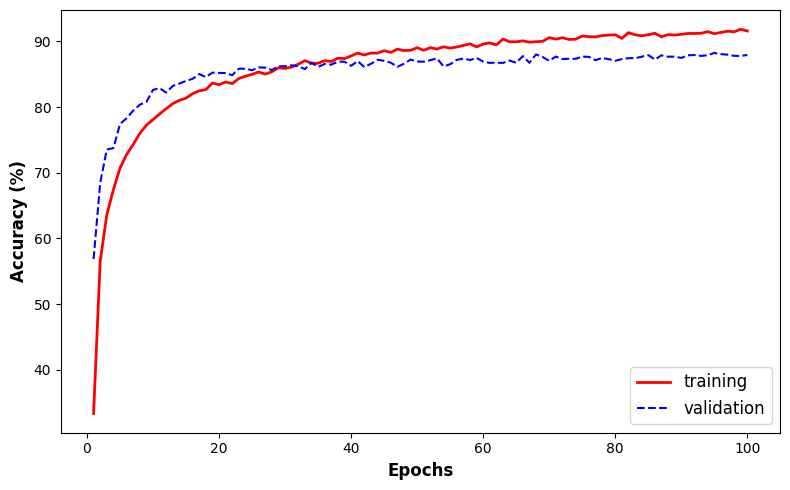

In [ ]:
# PLot the accuracy and validation accuracy graphs.
epochs = np.arange(len(accruacy)) + 1
fig = plt.figure(figsize=(8, 5))
plt.plot(epochs, np.array(accruacy) * 100, color='r', ls='-', lw=2, label='training')
plt.plot(epochs, np.array(val_accuracy) * 100, color='b', ls='--', lw=1.5, label='validation')
plt.legend(fontsize=12)
plt.xlabel('Epochs', fontsize=12, fontweight='bold', color='k')
plt.ylabel('Accuracy (%)', fontsize=12, fontweight='bold', color='k')
fig.tight_layout()


### Do predictions with the model and calculate the performance metrics

In [ ]:
# Do predictions for the testing dataset.
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

In [ ]:
# Calculate the performance matrices.
precision_macro = precision_score(y_test, y_pred, average='macro')
precision_micro = precision_score(y_test, y_pred, average='micro')
precision_weighted = precision_score(y_test, y_pred, average='weighted')
recall_macro = recall_score(y_test, y_pred, average='macro')
recall_micro = recall_score(y_test, y_pred, average='micro')
recall_weighted = recall_score(y_test, y_pred, average='weighted')
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_micro = f1_score(y_test, y_pred, average='micro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')
confMat = confusion_matrix(y_test, y_pred)

# Printing the results.
print(f'Precision score: macro:{precision_macro*100:.2f}%, macro:{precision_micro*100:.2f}%, weighted:{precision_weighted*100:.2f}%')
print(f'recall score: macro:{recall_macro*100:.2f}%, macro:{recall_micro*100:.2f}%, weighted:{recall_weighted*100:.2f}%')
print(f'f1 score: macro:{f1_macro*100:.2f}%, macro:{f1_micro*100:.2f}%, weighted:{f1_weighted*100:.2f}%')


Precision score: macro:87.47%, macro:87.42%, weighted:87.47%
recall score: macro:87.42%, macro:87.42%, weighted:87.42%
f1 score: macro:87.37%, macro:87.42%, weighted:87.37%


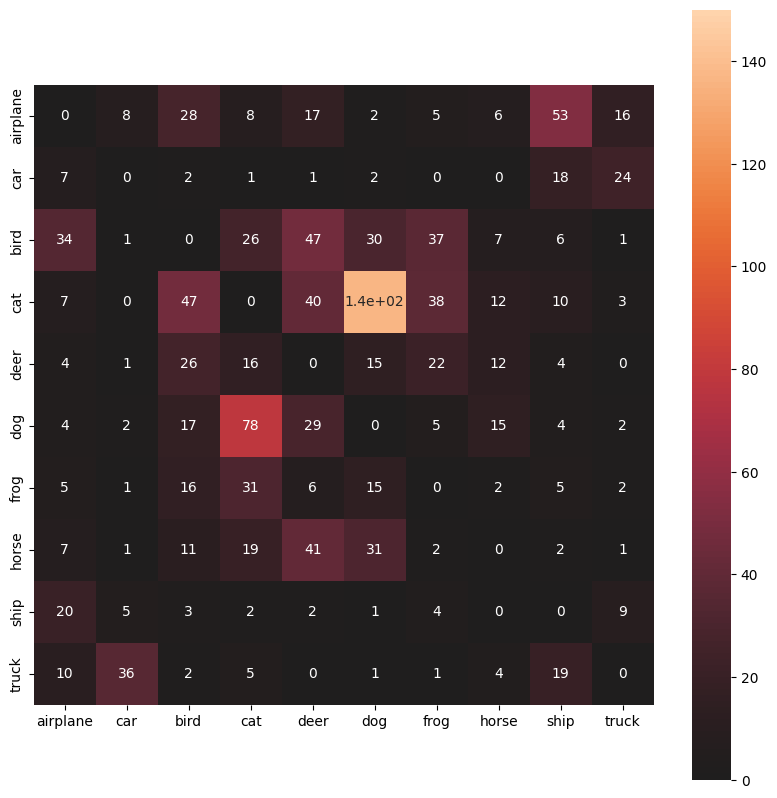

In [ ]:
# Zeroing the diagonal.
for i in range(confMat.shape[0]):
    confMat[i, i] = 0
# Plotting the confusion matrix. 
sns.heatmap(confMat, vmin=0, vmax=150, center=0, square=True, annot=True)
plt.gca().set_xticklabels(['airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
plt.gca().set_yticklabels(['airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
plt.gcf().set_figheight(10)
plt.gcf().set_figwidth(10)

In [ ]:
confMat

array([[  0,   8,  28,   8,  17,   2,   5,   6,  53,  16],
       [  7,   0,   2,   1,   1,   2,   0,   0,  18,  24],
       [ 34,   1,   0,  26,  47,  30,  37,   7,   6,   1],
       [  7,   0,  47,   0,  40, 136,  38,  12,  10,   3],
       [  4,   1,  26,  16,   0,  15,  22,  12,   4,   0],
       [  4,   2,  17,  78,  29,   0,   5,  15,   4,   2],
       [  5,   1,  16,  31,   6,  15,   0,   2,   5,   2],
       [  7,   1,  11,  19,  41,  31,   2,   0,   2,   1],
       [ 20,   5,   3,   2,   2,   1,   4,   0,   0,   9],
       [ 10,  36,   2,   5,   0,   1,   1,   4,  19,   0]])